In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [2]:
# Define image dimensions and batch size
img_width, img_height = 200, 200
batch_size = 32

In [3]:
# Extract class labels from folder names in the training directory
train_dir = 'training'
class_names = sorted(os.listdir(train_dir))

In [4]:
# Create data generators with increased data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,  # Increase rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],  # Increase brightness range
    horizontal_flip=True,
    validation_split=0.2
)


In [5]:
# Data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [6]:
# Load MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')


In [7]:
# Fine-tune MobileNetV2 by unfreezing some layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100


In [8]:
# Freeze all layers before the fine-tune layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [9]:
# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


In [10]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [12]:
# Train the model for more epochs
epochs = 40
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/40
142/142 [==============================] - 113s 765ms/step - loss: 0.7277 - accuracy: 0.7118 - val_loss: 1.6872 - val_accuracy: 0.5196
Epoch 2/40
142/142 [==============================] - 108s 763ms/step - loss: 0.3409 - accuracy: 0.8735 - val_loss: 1.0871 - val_accuracy: 0.6420
Epoch 3/40
142/142 [==============================] - 104s 734ms/step - loss: 0.2588 - accuracy: 0.9057 - val_loss: 0.7055 - val_accuracy: 0.7473
Epoch 4/40
142/142 [==============================] - 103s 723ms/step - loss: 0.2007 - accuracy: 0.9266 - val_loss: 0.5773 - val_accuracy: 0.8188
Epoch 5/40
142/142 [==============================] - 103s 727ms/step - loss: 0.1698 - accuracy: 0.9370 - val_loss: 0.3639 - val_accuracy: 0.8857
Epoch 6/40
142/142 [==============================] - 109s 764ms/step - loss: 0.1484 - accuracy: 0.9471 - val_loss: 0.4680 - val_accuracy: 0.8679
Epoch 7/40
142/142 [==============================] - 108s 760ms/step - loss: 0.1443 - accuracy: 0.9493 - val_loss: 0.4587 -

In [13]:
# Evaluate the model on the test set
test_generator = train_datagen.flow_from_directory(
    'testing',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [14]:
# Get true and predicted labels
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=-1)


41/41 [==============================] - 26s 612ms/step


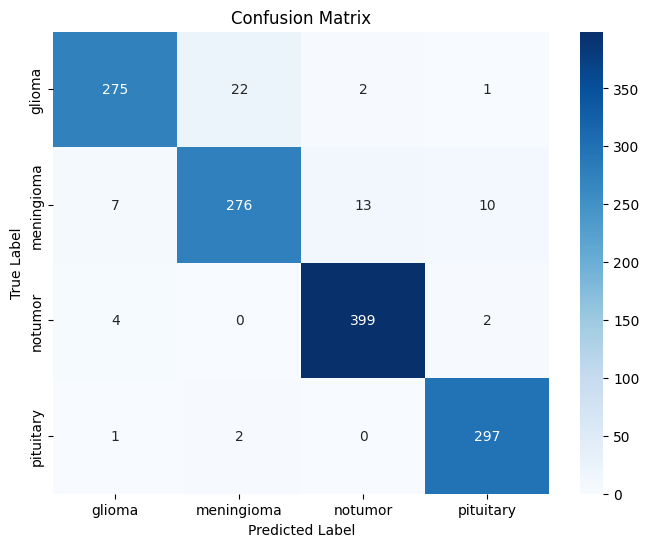

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       300
  meningioma       0.92      0.90      0.91       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [15]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with folder names as labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report with folder names as labels
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


C:\Users\kalpa\AppData\Local\Temp\ipykernel_22856\3140352687.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


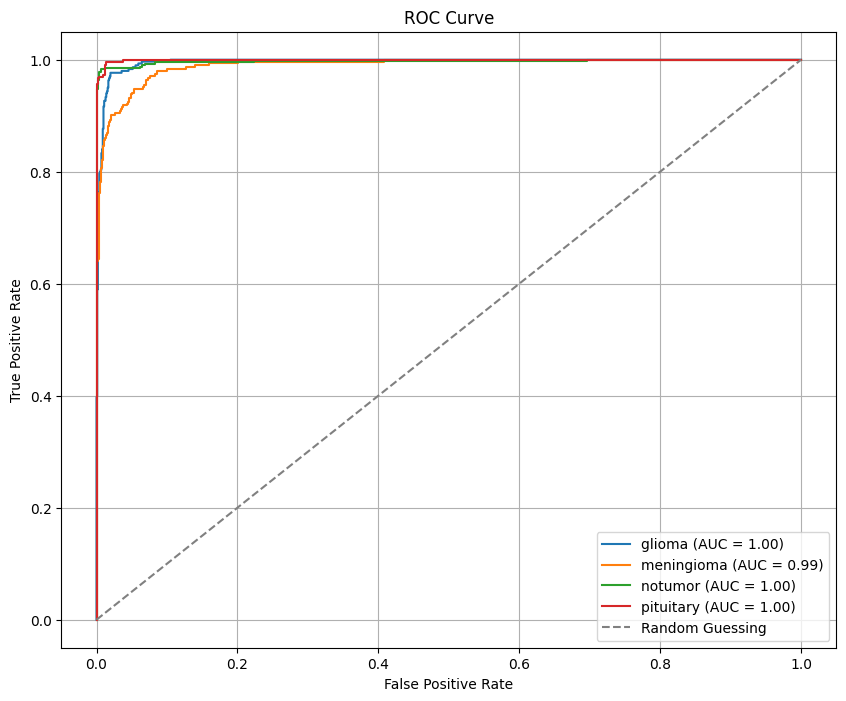

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# %%
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Save the model
model.save('mobilenetv2_tumor_detection_model.h5')

C:\Users\kalpa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
